<a href="https://colab.research.google.com/github/Vasanthpathi549/Mini-Project/blob/master/Product_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Import Libraries**

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
# import warnings; warnings.simplefilter('ignore')
# %matplotlib inline

**2.Load the dataset and add headers**

In [0]:
electronics_data=pd.read_csv("ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])

In [5]:
#Display the data
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [6]:
#shape of data
electronics_data.shape

(154914, 4)

In [0]:
#Taking subset of the dataset
electronics_data=electronics_data.iloc[:150000,0:]

In [9]:
#Check the datatypes
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp    float64
dtype: object

In [10]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 4 columns):
userId       150000 non-null object
productId    150000 non-null object
Rating       150000 non-null float64
timestamp    150000 non-null float64
dtypes: float64(2), object(2)
memory usage: 4.6+ MB


In [11]:
#Five point summary 
electronics_data.describe()['Rating'].T

count    150000.000000
mean          4.018587
std           1.362282
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

In [12]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


The rating of the product range from 0 to 1

**Handling Missing Values**

In [13]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


**Ratings**

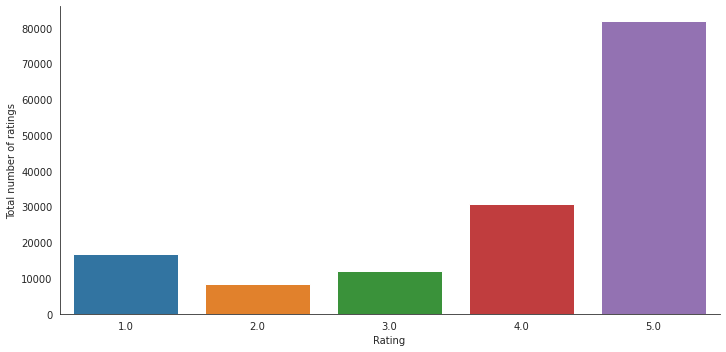

In [14]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=electronics_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

Most of the people has given the rating of 5

**Unique users and products**

In [15]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 150000
Total No of Users   : 132368
Total No of products  : 9734


**Dropping the timestamp column**

In [0]:
#Dropping the Timestamp column
electronics_data.drop(['timestamp'], axis=1,inplace=True)

**Analysing the rating**

In [17]:
#Analysis of rating given by the user 
no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

userId
A231WM2Z2JL0U3    169
A5JLAU2ARJ0BO      56
A2BGZ52M908MJY     54
A1MJMYLRTZ76ZX     41
AT2J7H5TRZM8Z      41
Name: Rating, dtype: int64

In [18]:
no_of_rated_products_per_user.describe()

count    132368.000000
mean          1.133204
std           0.875483
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         169.000000
Name: Rating, dtype: float64

In [0]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

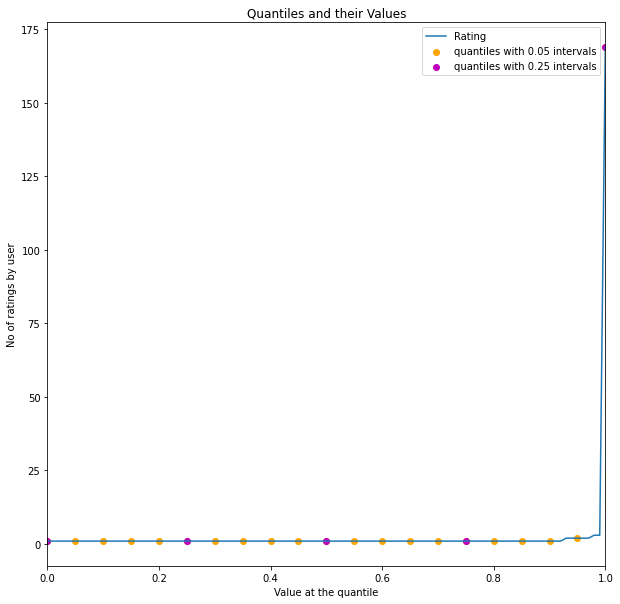

In [21]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [22]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 3



#Popularity Based Recommendation
Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.

In [0]:
#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

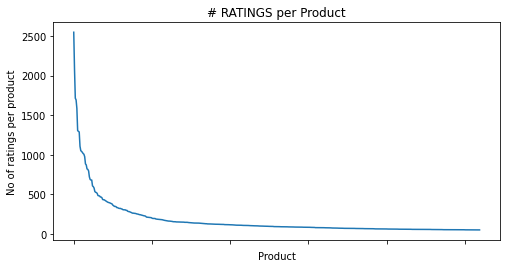

In [24]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [25]:
#Average rating of the product 
new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [0]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

In [27]:
#Total no of rating for product
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B00004ZCJE    2547
B00001P4ZH    2075
B000065BP9    1714
B00004T8R2    1692
B00001WRSJ    1586
Name: Rating, dtype: int64

In [0]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [0]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [30]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [31]:
ratings_mean_count['rating_counts'].max()

2547

<Figure size 576x432 with 0 Axes>

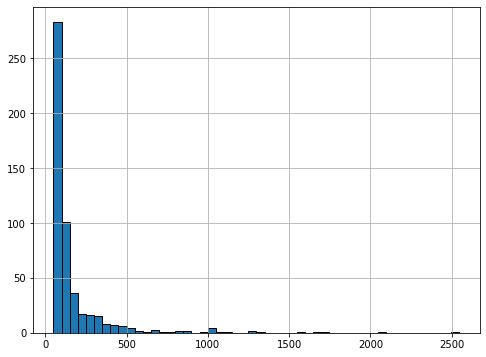

In [33]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)


<Figure size 576x432 with 0 Axes>

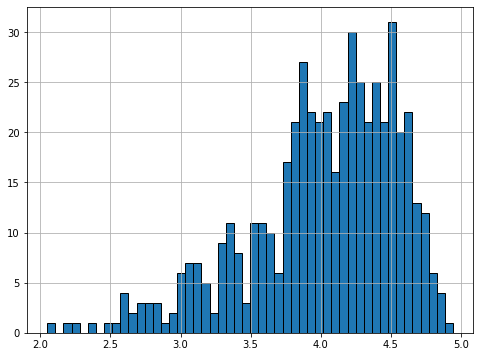

In [34]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

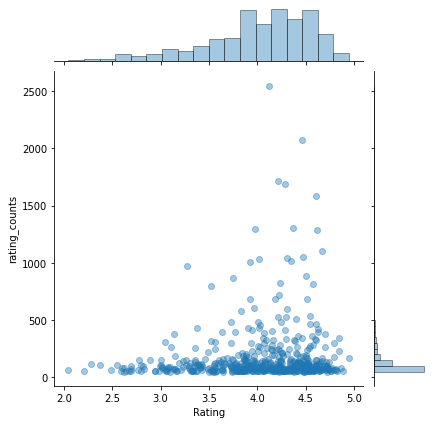

In [35]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

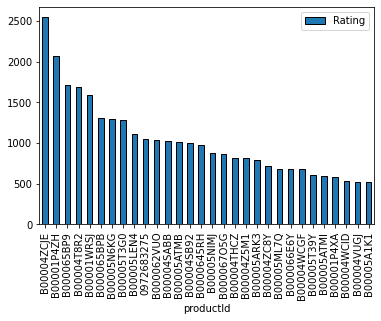

In [36]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

# **Collaberative filtering (Item-Item recommedation)**
Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. We are going to use collaborative filtering (CF) approach. CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item.Collaborative filtering has two sub-categories that are generally called memory based and model-based approaches.